Define input data:

In [1]:
import numpy as np

x = np.linspace(0, 2, 5)
y = np.exp(x)

Interpolation with RBF functions

In [4]:
# Define RBF utilities (1D)
import numpy as np

def rbf_function(radius: np.ndarray, eps: float):
    return np.exp(-eps ** 2 * radius ** 2)

def get_rbf_matrix(interpolation_points: np.ndarray, centers: np.ndarray, eps: float = 0.1) -> np.ndarray:
    rbf_matrix = np.zeros(shape = (centers.shape[0], centers.shape[0]))
    for row_index in range(centers.shape[0]):
        rbf_matrix[row_index, :] = rbf_function(radius = np.abs(interpolation_points[row_index] - centers),
                                                 eps = eps)
    return rbf_matrix

from typing import Callable
def get_rbf_interpolant(interpolation_points: np.ndarray, centers: np.ndarray, 
                        interpolation_targets: np.ndarray, eps: float = 0.1) -> Callable:
    matrix = get_rbf_matrix(interpolation_points, centers, eps)
    # coefficients = np.linalg.solve(matrix, interpolation_targets)
    coefficients = np.matmul(np.linalg.inv(matrix), interpolation_targets)
    def fn(x: float):
        return np.dot(rbf_function(radius = np.abs(x - centers), eps = eps), coefficients)
    return fn

In [5]:
# Get coefficients of interpolation with RBF functions
eps = .5
eps_sq = eps ** 2
matrix = get_rbf_matrix(x, x, eps)
print(f'Conditioning of matrix: {np.linalg.cond(matrix)}')
explicit_coefficients = np.linalg.solve(matrix, y) # a0, a1, a2, ..., aN
explicit_coefficients = np.flip(explicit_coefficients) # aN, ..., a2, a1, a0
print(f'Coefficients: {explicit_coefficients}')

fn = get_rbf_interpolant(x, x, y, eps)

Conditioning of matrix: 53053.99016568898
Coefficients: [ 265.43699949 -745.29972158  911.04366433 -566.81301725  150.96019897]


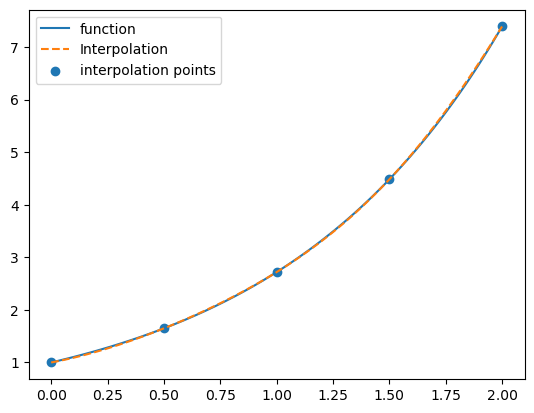

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 100)
plt.plot(x_np, np.exp(x_np), label = "function")

y_interp_inv = [fn(x_int) for x_int in x_np]
plt.plot(x_np, y_interp_inv, label="Interpolation", linestyle='--')

plt.scatter(x, y, label = "interpolation points")
plt.legend()

Interpolation with variational model

In [9]:
import torch

Define RBF model:

In [10]:
# Define the RBF kernel
def rbf_kernel(radius: torch.Tensor, eps: float):
    return torch.exp(-eps ** 2 * radius ** 2)

# Define the RBF interpolant model
class RBFInterpolant(torch.nn.Module):
    def __init__(self, centers: torch.Tensor, eps: float = 1.0):
        super(RBFInterpolant, self).__init__()
        self.eps = eps
        self.alphas = torch.nn.Parameter((torch.rand_like(centers) - 0.5))
        self.centers = centers

    def forward(self, x: torch.Tensor):
        radius = torch.stack([torch.abs(x_input - self.centers) for x_input in x])
        products_list = self.alphas * rbf_kernel(radius, self.eps)
        return torch.sum(products_list, dim = 1)

In [7]:
x_torch = torch.tensor(x)
y_torch = torch.exp(x_torch)
my_interp = RBFInterpolant(centers=x_torch, eps=eps)

In [8]:
loss_list = []
alphas_progress = torch.zeros(1, 5)

In [9]:
print(my_interp.alphas)
print(explicit_coefficients)

Parameter containing:
tensor([-0.4572,  0.3923,  0.2725, -0.2824,  0.3815], dtype=torch.float64,
       requires_grad=True)
[ 265.43699949 -745.29972158  911.04366433 -566.81301725  150.96019897]


In [10]:
print(y_torch)
print(my_interp(x_torch))

tensor([1.0000, 1.6487, 2.7183, 4.4817, 7.3891], dtype=torch.float64)
tensor([0.1030, 0.2162, 0.3168, 0.3770, 0.3838], dtype=torch.float64,
       grad_fn=<SumBackward1>)


In [16]:
it = 1
optimizer = torch.optim.Adam(my_interp.parameters(), lr=1e-3)
while True:
    # Calculate RBF values
    loss = torch.mean(torch.sum((my_interp(x_torch) - y_torch) ** 2))

    # Store loss and alphas
    loss_list += [loss.item()]
    alphas_progress = torch.cat((alphas_progress, torch.zeros(1, 5)))
    alphas_progress[-1, :] = my_interp.alphas

    # Update parameters
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f'{it} loss: {loss_list[-1]}', end='\r')
    if it % 30000 == 0:
        break
    it = it + 1
        

In [18]:
print(my_interp.alphas)
print(explicit_coefficients)

Parameter containing:
tensor([-41.6571,  83.4451, -11.3244, -93.8024,  72.0907], dtype=torch.float64,
       requires_grad=True)
[ 265.43699949 -745.29972158  911.04366433 -566.81301725  150.96019897]


Text(0.5, 1.0, 'Loss function (log10), MSE')

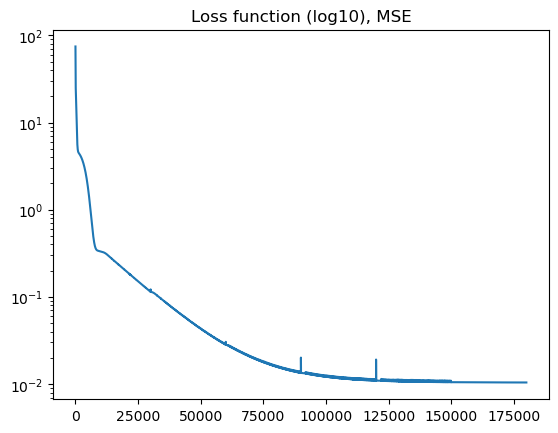

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.semilogy(loss_list)
plt.title("Loss function (log10), MSE")

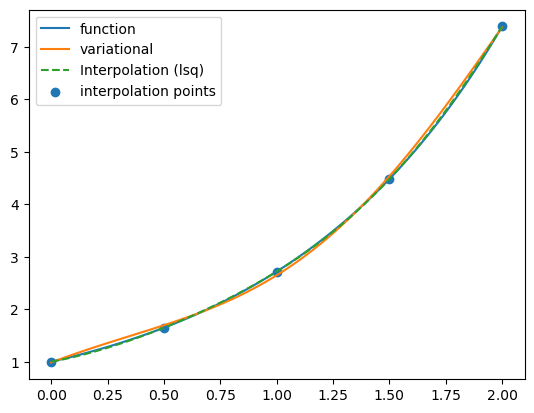

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 100)
plt.plot(x_np, np.exp(x_np), label = "function")

plt.plot(x_np, my_interp(torch.from_numpy(x_np)).detach().numpy(), label = "variational")

y_interp_inv = [fn(x_int) for x_int in x_np]
plt.plot(x_np, y_interp_inv, label="Interpolation (lsq)", linestyle='--')

plt.scatter(x, y, label = "interpolation points")
plt.legend()

/tmp/ipykernel_39798/2260319694.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


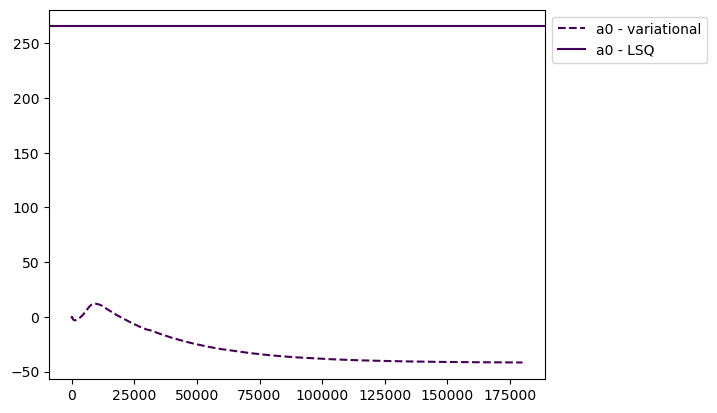

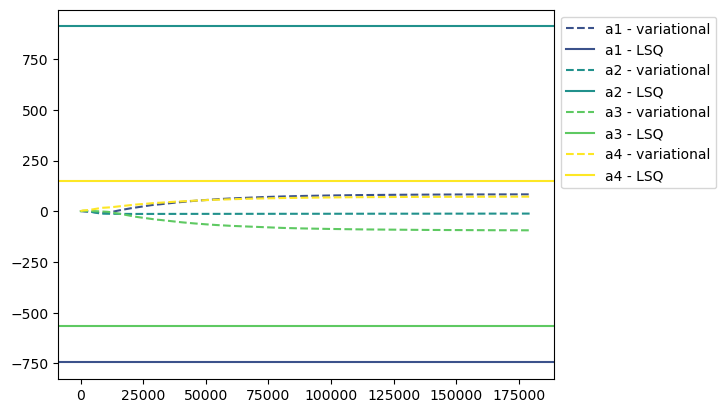

In [21]:
alphas_numpy = alphas_progress.detach().numpy()
# Get a colormap
cmap = plt.cm.get_cmap('viridis')

# Get 20 distinct colors from the colormap
colors = cmap(np.linspace(0, 1, 5))

for index in range(alphas_numpy.shape[1]):
    plt.plot(alphas_numpy[:, index], label=f"a{index} - variational", linestyle='--', color=colors[index % 5])
    plt.axhline(explicit_coefficients[index], label=f"a{index} - LSQ", color=colors[index % 5])
    if index % 5 == 0 or index == alphas_numpy.shape[1] - 1:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

In [22]:
print(my_interp.alphas)
print(explicit_coefficients)

Parameter containing:
tensor([-41.6571,  83.4451, -11.3244, -93.8024,  72.0907], dtype=torch.float64,
       requires_grad=True)
[ 265.43699949 -745.29972158  911.04366433 -566.81301725  150.96019897]
